Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Радует, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* Отлично, что стоп-слова были исключены при векторизации!
* Работа получилась отличной, тебе удалось добиться достаточно хорошего качества. Поздравляю!
* Проект зачтен, удачи в дальнейшем обучении!

<div class="alert alert-block alert-warning">
Привет, спасибо за ревью
</div>

### <font color='orange'>Общее впечатление (ревью 2)</font>
* После изменений проект улучшился и может быть зачтен.
* Удачи в дальнейшем обучении и будущих работах!

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Содержание
* [Подготовка](#prepare_data)
* [Обучение](#model_train)
* [Выводы](#model_analysis)

In [1]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import f1_score

from lightgbm import LGBMRegressor 
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 

import time
from collections import namedtuple
import re

RANDOM_STATE = 12345

nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
def analyze_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    df.info()

def lemmatize(text): 
    tokens = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

def clear_text(text):
    return ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split())

<a name="prepare_data"></a>
## Подготовка

Загрузим даннные из файла 

In [3]:
comments_df = pd.read_csv('/datasets/toxic_comments.csv')
analyze_df(comments_df)

Количество стобцов: 2
Количество строк: 159571


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно. 
</div>

Заметно, что токсичных комментариев заметно меньше, чем обычных

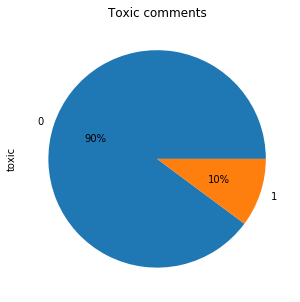

In [4]:
comments_df['toxic'].value_counts().plot(
    kind='pie', 
    figsize=(10, 5), 
    legend=False, 
    title='Toxic comments', 
    autopct='%1.0f%%'
)
plt.show()

В датасете всего 10% токсичных комментариев 

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что заметил и исследовал дисбаланс классов.
</div>

Очистим и лемматизируем текст 

In [5]:
corpus = []
for comment in comments_df['text']: 
    corpus.append(lemmatize(clear_text(comment)))

In [6]:
print(comments_df['text'][0])
print(corpus[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что очистка и лемматизация были проведены именно в таком порядке.
</div>

Выделим фичи (очищенные и лемматизированные комментарии) и целевой показатель `toxic`

In [7]:
features = corpus
target = comments_df['toxic']

Разделим данные на обучающую и тестовую выборки

In [8]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

Вычислим TF-IDF для обучающей и тестовой выборки 

In [12]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Векторизатор нужно обучать только на тренировочной выборке. Иначе, может возникнуть переобучение.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Поправил и теперь обучение происходит только на тренировочной выборке
</div>

<a name="model_train"></a>
## Обучение

### LogisticRegression

In [14]:
model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [10, 100],
}

search_lr = GridSearchCV(model, param_grid, cv=5, verbose=1, scoring='f1')
search_lr.fit(features_train, target_train)

print(search_lr.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  8.4min finished


0.7604162463881727


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> В GridSearchCV необходимо было передать в scoring параметр целевую метрику. В данном случае можно передать строку 'f1'.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Указал метрику f1
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Также желательно было еще подобрать параметр "C".
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Добавил параметр С 
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> В целом, радует, что для подбора парамтеро исопльзовался GridSearchCV.
</div>

### RandomForestClassifier

In [15]:
model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

param_grid = {
    'max_depth': [2, 6, 10],
    'n_estimators': [10, 30, 50],
}

search_rf = GridSearchCV(model, param_grid, cv=5, verbose=1, scoring='f1')
search_rf.fit(features_train, target_train)

print(search_rf.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.1min finished


0.34634606116937167


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Скор, который ты печатаешь на экран – это не F-мера, так что выбирать модель на его основе не имеет смысла.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Указал метрику f1 в GridSearchCV
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что ты попробовал несколько различных моделей и подобрал к ним параметры.
</div>

<a name="model_analysis"></a>
## Выводы

Выберем лучшую модель (LogisticRegression) и проверим метрику на тестовой выборке

In [16]:
model = search_lr.best_estimator_

model.fit(features_train, target_train)
predictions = model.predict(features_test)

print(f1_score(target_test, predictions))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7626002290950744


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


В этом проекте была решена задача классификации тональности комментариев.
Сначала данные были очищены и лемматизированы.
После этого для тестовой и обучающей выборок был вычислен TF-IDF.
Затем на этих данных было обучено 2 модели: LogisticRegression и RandomForestClassifier. В качестве метрики качества была использована f1.
Лучшее значение метрики f1 показала моделт LogisticRegression и на тестовой выборке значение мерики f1 составило 0.763, что больше, чем требуемая в условии. 0.75 

<div class="alert alert-block alert-info">
<b>Совет: </b> Общий вывод можно было бы сделать подробнее.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Дополнил вывод
</div>

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны